# Predicting breast cancer from digitized images of breast mass

by Rebecca Sokol-Snyder, William Song, and Chung Ki (Harry) Yau 2025/11/22

## Summary

We retrieved the public Park data from the City of Vancouver Open Data Portal. We aim to construct a classification model using the adequate algorithm to help us evaluate the factors that influenced the construction of washroom which is one of the important amenities in public parks. We used two models, KNN and SVM RBVF, to test our data.

The cross-validation result shows that SVM RBF provides a small but consistent improvement over the baseline, while KNN overfits and fails to generalize. The dataset may require richer features or alternative models to achieve stronger predictive performance on washroom availability.

## Introduction
The Vancouver parks dataset (City of Vancouver 2025) offers a comprehensive view of the city’s green spaces, capturing details from park names and neighbourhoods to special features and facilities. The Washrooms column is particularly valuable, as it reveals which parks provide public washrooms and which do not. By linking this information to neighbourhoods and park sizes, the dataset becomes a powerful tool for assessing accessibility and identifying gaps in essential amenities across Vancouver’s park system.

By treating washroom presence as a target variable, we wonder if we can use machine learning algorithm to help us predict where facilities are most needed, identify underserved neighbourhoods, and optimize future installations. Using features such as park size, amenities, and neighbourhood context, ML models can uncover hidden patterns in service distribution and guide equitable infrastructure planning.

## Methodology

### Data
The data set that was used in this project is from City of Vancouver Open Data Portal. There are over 220 parks and 40 major facilities in the city of Vancouver maintained by the Vancouver Board of Parks and Recreation. In the data set, it has covered 218 park information regarding facilities available to the parks, their locations, and sizes.

### Analysis
We compared the performance of a k-nearest neighbors (k-nn) algorithm and a Support Vector Machine with Radial Basis Function (SVM RBF) algorithm to build a binary classification model to predict whether a park has washrooms or not. We included neighbourhood name, park size (hectare), whether the park is official, whether there are any advisories, whether there are additional facilities and whether the park has special features to fit the model. Data was split with 70% of the original dataset in the training set and the remaining 30% in the test set. We conducted 5-fold cross-validation to compare the models with a baseline. All variables preprocessed just before model fitting to ensure reliability.

## Results and Discussion
To look at whether the chosen features might be helpful in predicting the existance of washrooms in Vancouver parks we began with some Exploratory Data Analysis (EDA). We analyze the counts of binary features in parks based on the presence of washrooms to identify patterns in park amenities. The results shows that parks with washrooms tend to be associated with  higher counts of other amenities compared to those without washrooms. We then used a histogram to visualize the the number of hectares of a park based on the presence of washrooms.We can see a significant difference in the hectare size of a park when washrooms are present or not. The parks with washrooms tend to be larger in size compared to those without washrooms. Finally, categorical features are also visualized using bar charts to show the distribution of different categories based on the presence of washrooms in parks. 

3 models were used to predict the presence of washrooms in parks based on the binary, numeric and categorical features. The models used were KNN, SVC with RBF kernal and Dummy classification. The performance of each model was evaluated using cross validation score. The results indicate that the SVC with RBF kernal model had a better performance than the other two models in predicting the presence of washrooms in parks.

The analysis reveals that parks equipped with washrooms generally offer a wider range of amenities and larger hectare compared to those without washrooms. This suggests that parks with washrooms may be designed to accommodate more visitors and provide a more comprehensive recreational experience. The presence of washrooms could be an indicator of a park's overall quality and the level of services it provides to the public.

In [1]:
import json
import logging
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import pandera.pandas as pa
from deepchecks.tabular import Dataset
from deepchecks.tabular.checks import FeatureLabelCorrelation
from deepchecks.tabular.checks.data_integrity import FeatureFeatureCorrelation

/Users/rebeccasokol-snyder/miniforge3/envs/milestone1/lib/python3.12/site-packages/deepchecks/core/serialization/dataframe/html.py:16: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



In [2]:
# read data

# Data Validation: correct file format
try: 
    park = pd.read_csv("https://opendata.vancouver.ca/api/explore/v2.1/catalog/datasets/parks/exports/csv?lang=en&timezone=America%2FLos_Angeles&use_labels=true&delimiter=%3B", sep=";")
except:
    raise Exception("File appears to be in the incorrect format!")
park.to_csv("../data/parks.csv", sep=';')
park

,ParkID,Name,Official,Advisories,SpecialFeatures,Facilities,Washrooms,StreetNumber,StreetName,EWStreet,NSStreet,NeighbourhoodName,NeighbourhoodURL,Hectare,GoogleMapDest
0,2,Carnarvon Park,1,N,N,Y,Y,2995,W 19th Avenue,W 19th Avenue,Mackenzie Street,Arbutus-Ridge,https://vancouver.ca/news-calendar/arbutus-rid...,3.79,"49.256555, -123.171406"
1,13,Coal Harbour Park,1,N,N,Y,N,480,Broughton Street,W Hastings Street,Broughton Street,Downtown,https://vancouver.ca/news-calendar/downtown.aspx,0.95,"49.289981, -123.125015"
2,16,David Lam Park,1,N,Y,Y,Y,1300,Pacific Boulevard,Drake Street,Pacific Boulevard,Downtown,https://vancouver.ca/news-calendar/downtown.aspx,4.34,"49.272569, -123.124145"
3,25,May & Lorne Brown Park,1,N,N,N,N,801,Beach Avenue,Beach Avenue,Hornby Street,Downtown,https://vancouver.ca/news-calendar/downtown.aspx,0.25,"49.275188, -123.132046"
4,26,Pioneer Place (Pigeon Park),1,N,N,N,N,399,Carrall Street,W Hastings Street,Carrall Street,Downtown,https://vancouver.ca/news-calendar/downtown.aspx,0.03,"49.281699, -123.104588"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,235,Granville Island Water Park,0,N,N,Y,N,1348,Cartwright Street,NaN,NaN,Fairview,https://vancouver.ca/news-calendar/fairview.aspx,0.00,"49.26955, -123.135064"
214,237,Yaletown Park,1,N,N,N,N,901,Mainland Street,Mainland Street,Nelson Street,Downtown,https://vancouver.ca/news-calendar/downtown.aspx,0.17,"49.277042, -123.118921"
215,238,Carolina Park,1,N,N,N,N,2100,Carolina Street,E 5th Avenue,Carolina Street,Mount Pleasant,https://vancouver.ca/news-calendar/mount-pleas...,0.08,"49.266401, -123.090778"
216,241,Habitat Island,0,N,N,N,N,1616,Columbia Street,NaN,NaN,Mount Pleasant,https://vancouver.ca/news-calendar/mount-pleas...,0.60,"49.27221, -123.110791"


In [3]:
# Pandera data validation
# no check for missingness threshold since the only nullable columns are dropped
# so we do not care about how many nulls there are

# set up invalid data logging
# adapted from DSCI 522 Textbook
logging.basicConfig(
    filename="../logs/validation_errors.log",
    filemode="w",
    format="%(asctime)s - %(message)s",
    level=logging.INFO,
)

# Configure valid data schema
schema = pa.DataFrameSchema(
    {
        "ParkID": pa.Column(int),
        "Name": pa.Column(str),
        "Official": pa.Column(int, pa.Check.isin([0,1])),
        "Advisories": pa.Column(str, pa.Check.isin(["Y", "N"])),
        "SpecialFeatures": pa.Column(str, pa.Check.isin(["Y", "N"])),
        "Facilities": pa.Column(str, pa.Check.isin(["Y", "N"])),
        "Washrooms": pa.Column(str, pa.Check.isin(["Y", "N"])),
        "StreetNumber": pa.Column(int, pa.Check.between(1, 10000), required=False),
        "StreetName": pa.Column(str, required=False),
        "EWStreet": pa.Column(str, nullable=True, required=False),
        "NSStreet": pa.Column(str, nullable=True, required=False),
        "NeighbourhoodName": pa.Column(str, pa.Check.isin([
            "Arbutus-Ridge",
            "Downtown",
            "Dunbar-Southlands",
            "Fairview",
            "Grandview-Woodland",
            "Hastings-Sunrise",
            "Kensington-Cedar Cottage",
            "Kerrisdale",
            "Killarney",
            "Kitsilano",
            "Mount Pleasant",
            "South Cambie",
            "Renfrew-Collingwood",
            "Oakridge",
            "Riley Park",
            "Shaughnessy",
            "Victoria-Fraserview",
            "West End",
            "West Point Grey",
            "Marpole",
            "Strathcona",
            "Sunset"
        ])),
        "NeighbourhoodURL": pa.Column(str, 
            checks=[
                pa.Check(lambda url: url.str.startswith("https://vancouver.ca")),
                pa.Check(lambda url: url.str.endswith(".aspx"))
            ],
            nullable=True
        ),
        "Hectare": pa.Column(float, pa.Check.between(0, 400)),
        "GoogleMapDest": pa.Column(str, 
            pa.Check(lambda latlon: latlon.str.startswith("49.")),
            nullable=True
        )
    },
    checks=[
        pa.Check(lambda df: ~df.duplicated().any(), error = "Duplicate Rows!"),
        pa.Check(lambda df: ~(df.isna().all(axis=1)).any(), error = "Empty Rows!")
    ],
    drop_invalid_rows=False
)

# Adapted from DSCI 522 Textbook
# Initialize error cases DataFrame
error_cases = pd.DataFrame()
data = park.copy()

# Adapted from DSCI 522 Textbook
# Validate data and handle errors
try:
    park = schema.validate(data, lazy=True)
except pa.errors.SchemaErrors as e:
    error_cases = e.failure_cases

    # Adapted from DSCI 522 Textbook
    # Convert the error message to a JSON string
    error_message = json.dumps(e.message, indent=2)
    logging.error("\n" + error_message)

# Filter out invalid rows based on the error cases
if not error_cases.empty:
    invalid_indices = error_cases["index"].dropna().unique()
    park = (
        data.drop(index=invalid_indices)
        .reset_index(drop=True)
        .drop_duplicates()
        .dropna(how="all")
    )
else:
    park = data

In [4]:
# train and test data set up
train_df, test_df = train_test_split(park, test_size=0.3, random_state=123)

In [5]:
# Data Validation Pandera check of target distribution

training_schema = pa.DataFrameSchema({
    "Washrooms": pa.Column(str, checks = [
        pa.Check(
            lambda w: (w == "Y").sum() / len(w) >= 0.2, 
            element_wise=False,
            error="Target Class may be imbalanced, check source data!"
        ),
        pa.Check(
            lambda w: (w == "N").sum() / len(w) >= 0.2, 
            element_wise=False,
            error="Target Class may be imbalanced, check source data!"
        )
                                    ])
})

train_df = training_schema.validate(train_df, lazy=True)

In [6]:
# listing features in dataframe
numeric_features = ['Hectare']
categorical_features = ['NeighbourhoodName']
binary_features = ['Official', 'Advisories', 'SpecialFeatures', 'Facilities']
drop_features = ['NeighbourhoodURL', 'ParkID', 'Name', 'GoogleMapDest', 'StreetNumber', 'StreetName', 'EWStreet', 'NSStreet']
target = "Washrooms"

In [7]:
# No anomalous correlations between target/response variable and features/explanatory variables
# Using Deepchecks Feature Label Correlation check

# Prepare dataset that matches Deepcheck syntax
dc_categorical_features = ['NeighbourhoodName', 'Official', 'Advisories', 'SpecialFeatures', 'Facilities']
dc_train_df = train_df.drop(columns = drop_features)
dc_test_df = test_df.drop(columns = drop_features)

# Checking procedure and result
fl_check_ds = Dataset(dc_train_df, label=target, cat_features=dc_categorical_features)
my_check = FeatureLabelCorrelation()
my_check.run(dataset=fl_check_ds)

In [8]:
# No anomalous correlations between features/explanatory variables
# Using Deepchecks Feature Feature Correlation check

# Checking procedure and result
ff_check_ds = Dataset(dc_train_df, cat_features=dc_categorical_features)
check = FeatureFeatureCorrelation()
check.add_condition_max_number_of_pairs_above_threshold(0.7, 3) # add self-defined threshold condition
check.run(ff_check_ds)

In [9]:
# Summary of dataframe
train_df.describe()

,ParkID,Official,StreetNumber,Hectare
count,152.000000,152.000000,152.000000,152.000000
mean,121.677632,0.907895,2728.934211,5.779605
std,72.236514,0.290130,2067.191692,32.782167
min,2.000000,0.000000,50.000000,0.000000
25%,60.250000,1.000000,1191.750000,0.380000
50%,118.500000,1.000000,2300.500000,1.140000
75%,181.750000,1.000000,3600.000000,3.212500
max,249.000000,1.000000,9149.000000,400.000000


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 152 entries, 41 to 109
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ParkID             152 non-null    int64  
 1   Name               152 non-null    object 
 2   Official           152 non-null    int64  
 3   Advisories         152 non-null    object 
 4   SpecialFeatures    152 non-null    object 
 5   Facilities         152 non-null    object 
 6   Washrooms          152 non-null    object 
 7   StreetNumber       152 non-null    int64  
 8   StreetName         152 non-null    object 
 9   EWStreet           150 non-null    object 
 10  NSStreet           148 non-null    object 
 11  NeighbourhoodName  152 non-null    object 
 12  NeighbourhoodURL   152 non-null    object 
 13  Hectare            152 non-null    float64
 14  GoogleMapDest      152 non-null    object 
dtypes: float64(1), int64(3), object(11)
memory usage: 19.0+ KB


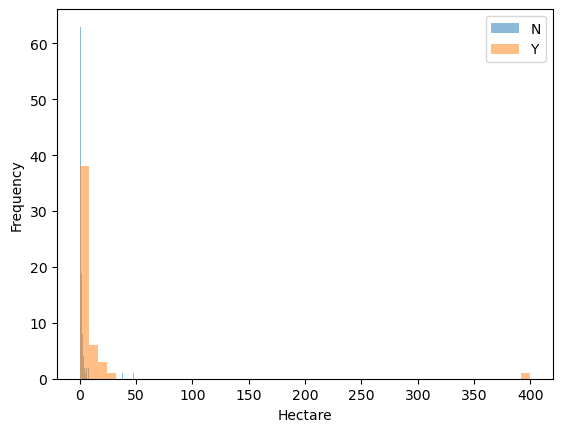

In [11]:
# Visualize numeric features
for col in numeric_features:
    train_df.groupby(target)[col].plot.hist(bins=50, alpha=0.5, legend=True)
    plt.xlabel(col);
    plt.show()

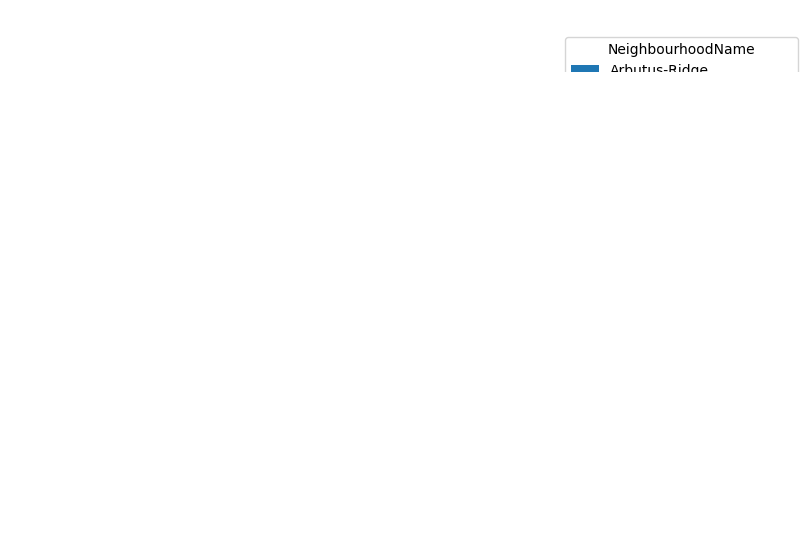

In [12]:
# Visualize categorical features
col = 'NeighbourhoodName'
cat_df = train_df[[col, target]].copy()
cat_df_count = cat_df.groupby([target, col]).size().unstack()
cat_df_count.plot.bar()
plt.title(col);
plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left');
plt.xlabel(col);
plt.show()


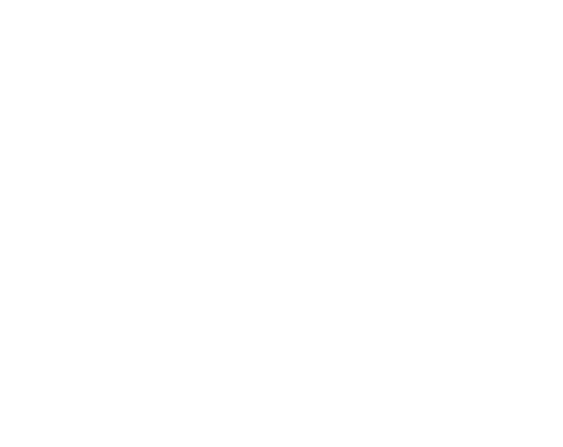

In [13]:
# Visualize binary features when there is washroom
binary_df = train_df[binary_features + [target]].copy()
binary_df['Official'] = binary_df['Official'].astype(str).replace({"1": "Y", "0": "N"})
washroom_df = binary_df[binary_df[target] == "Y"]
washroom_df_count = washroom_df.groupby(target)[binary_features].apply(lambda group: (group == "Y").sum())
washroom_df_count
washroom_df_count.plot.bar()
plt.title("Count of Binary Features when Washrooms are Present")
plt.ylabel("Count")
plt.show()

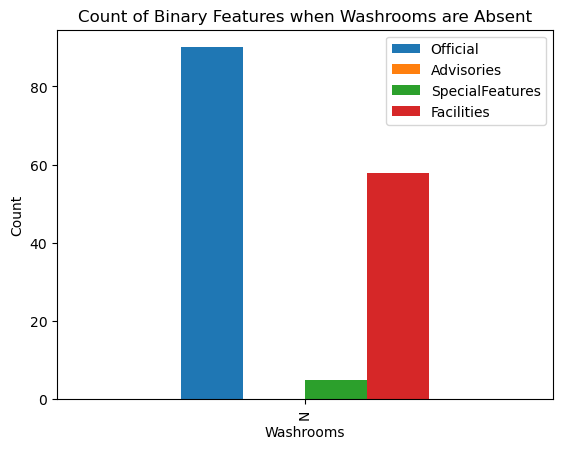

In [14]:
# Visualize binary features when there is no washroom
no_washroom_df = binary_df[binary_df[target] == "N"]
no_washroom_df_count = no_washroom_df.groupby(target)[binary_features].apply(lambda group: (group == "Y").sum())
no_washroom_df_count
no_washroom_df_count.plot.bar()
plt.title("Count of Binary Features when Washrooms are Absent")
plt.ylabel("Count")
plt.show()

In [15]:
X_train = train_df.drop(columns=[target])
y_train = train_df[target]
X_test = test_df.drop(columns=[target])
y_test = test_df[target]

In [16]:
# preprocessor for column transformation
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"), OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(), binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features)
)

In [17]:
# Function for cv score, adapted from 571 lab 2
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    Parameters
    ----------
    model :
    scikit-learn model
    X_train : numpy array or pandas DataFrame
    X in the training data
    y_train :
    y in the training data
    Returns
    ----------
    pandas Series with mean scores from cross_validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []
    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))
    return pd.Series(data=out_col, index=mean_scores.index)

In [18]:
# Setup model and pipline
model = DummyClassifier(random_state=123)
pipe = make_pipeline(preprocessor, model)

In [19]:
dummy_df = pd.DataFrame({
    "dummy" : mean_std_cross_val_scores(pipe, X_train, y_train, cv=5, return_train_score=True)
})
dummy_df.transpose()

,fit_time,score_time,test_score,train_score
dummy,0.006 (+/- 0.001),0.004 (+/- 0.000),0.678 (+/- 0.014),0.678 (+/- 0.003)


In [20]:
# RBF SVC model implementation
svm_rbf_classifier = SVC(kernel='rbf', C=1.0, gamma='scale') 
pipe2 = make_pipeline(preprocessor, svm_rbf_classifier)
svm_rbf_df = pd.DataFrame({
    "svm_rbf" : mean_std_cross_val_scores(pipe2, X_train, y_train, cv=5, return_train_score=True)
})
svm_rbf_df.transpose()

,fit_time,score_time,test_score,train_score
svm_rbf,0.008 (+/- 0.001),0.005 (+/- 0.002),0.710 (+/- 0.065),0.765 (+/- 0.041)


In [21]:
# knn model implementation
knn_classifier = KNeighborsClassifier(n_neighbors=5)
pipe3 = make_pipeline(preprocessor, knn_classifier)
knn_df = pd.DataFrame({
    "knn" : mean_std_cross_val_scores(pipe3, X_train, y_train, cv=5, return_train_score=True)
})
knn_df.transpose()

,fit_time,score_time,test_score,train_score
knn,0.006 (+/- 0.000),0.013 (+/- 0.020),0.651 (+/- 0.065),0.819 (+/- 0.018)


In [22]:
result = pd.merge(dummy_df, svm_rbf_df, left_index=True, right_index=True)
result = pd.merge(result, knn_df, left_index=True, right_index=True)
result

,dummy,svm_rbf,knn
fit_time,0.006 (+/- 0.001),0.008 (+/- 0.001),0.006 (+/- 0.000)
score_time,0.004 (+/- 0.000),0.005 (+/- 0.002),0.013 (+/- 0.020)
test_score,0.678 (+/- 0.014),0.710 (+/- 0.065),0.651 (+/- 0.065)
train_score,0.678 (+/- 0.003),0.765 (+/- 0.041),0.819 (+/- 0.018)


Since the SVM RBF model performed best on the validation data, we finally fit that model on the entire training set and see how it performs on the test data set.

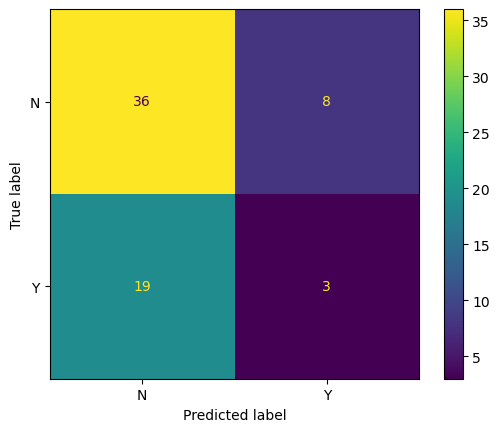

In [23]:
pipe2.fit(X_train, y_train)

cm = ConfusionMatrixDisplay.from_estimator(
    pipe2,
    X_test,
    y_test,
    values_format="d"
)
cm


## References

City of Vancouver. (2025, September 22). Parks. City of Vancouver Open Data Portal. https://opendata.vancouver.ca/explore/dataset/parks/information/

Timbers, T. (n.d.). breast_cancer_predictor_py [Source code]. GitHub. https://github.com/ttimbers/breast_cancer_predictor_py

Sci-Kit Learn Documentation. Dummy Classifier. https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

Sci-Kit Learn Documentation. KNeighborsRegressor. https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

Sci-Kit Learn Documentation. SVC. https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html